In [1]:
import torch
import netCDF4 as nc
import numpy as np
import torch
from time import perf_counter
import os
from unbalancedsinkhorn import DebiasedUOT

import matplotlib.pyplot as plt


In [2]:
# You may be required to install nedCDF4 pandas python package.
# Uncomment the following line to install it if needed:
# ! pip install netCDF4 pandas


# Initialise parameters and hyperparameters

In [3]:
# Set epsilon and rho
# Epsilon is set by the grid resolution, hence assuming you have set the grid to be
# O(1) of size (N) epsilon = 1/sqrt(N).
# For rectanglar grids with lengths (L1, L2) and number of points (L, n2), a suitable approximation 
# is epsilon = min(L1, L2)/(sqrt(L*n2)).
eps = 0.05

# Rho is set by the user and is related to the reach parameter. Recall this relation is strong for the tv regularsation than Kl.
# Call rho = sqrt(2*reach) and the reach is in units of distance beyound which there is a weaker association of features.
# If you have removed dimension from the grid, then rho should also be dimensionless.
rho = 1

# Pick type of regularisation,
# If the data is balanced yiou can caluate 'balanced' version which does not allow mass to be destroyed.
# Otherwsie is should be 'kl' or 'tv'.
aprox_type = 'kl' 

# DATA
# Data for the simple idealised geosmetric cases is avaliable from 
# https://projects.ral.ucar.edu/icp/Data/NewGeom/test_fields.zip

# Once downloaded and unzipped, provide the path to the data.
path_to_data = '/home/jacob/PhD_jobs/ICP_Cases/MescoVict_cases/' # this will need changing

# Choose idealised cases from any of those avaliable in the data folder.
case = ('C1', 'C6')

# If a device is visible then will use this by default.
if torch.cuda.is_available():
    cuda = 0
else:
    cuda = None # Default 'cpu' device


## Data scaling

ICP real cases, on true regular lon lat, it had size 501, 601.  Then I ignored the true lon lat, and created a mesh grid 501, 601 in [0,1] x[0,1]. If your grid has length scale [0, L1 km] and [0, L2 km], then rescale to order one by dividing by L = min(L1, L2).

L can be chosen as any of L1, L2, max, min or mean of L1,L2. As long as it is consisent and the sides end up with O(1) lengths.



<div class="alert alert-block alert-warning">
    <b> Note:</b> If the grid does not fill a rectangle, or is not regular you will still need to rescale using the forumla below. For the MesoVICT cases, the grid was regular but did not fill a rectangle, hence zere points were added so that a regular grid could be used for numerical speed ups. 
</div>


    (lon - lon_min) / min((lon_max - lon_min), (lat_max - lat_min))
    (lat - lat_min) / min((lon_max - lon_min), (lat_max - lat_min))


In [4]:
# An example of creating a regular mesh
L = 501
# You could alternatively use 601, or (501+601)//2
X, Y = torch.meshgrid(
    torch.linspace(0, 501, 501)/L,
    torch.linspace(0, 601, 601)/L,
    indexing='ij'
)

input = torch.stack((X, Y), dim=-1)

#### Density scaling
Pick an out-of-sample ideally. This could be climatogical, or historical average.
Scale  Observation and Forecast by the same number.
Leave out dry days.

    -ICP: I took in sample average
    -MesoVICT: I took the eobservation average
    -Real ICP: Observation average

<div class="alert alert-block alert-warning">
    <b> Note:</b> Below cases_scale enforces the total size/mass of the data/density, so that it is O(1). This is important for numerical stability and convergence. The average should be taken as the sum over the whole domain (not per grid point).
</div>

In [5]:

def load_test_fields_bias_scaling(fieldx: str, fieldy: str, L=200, dtype=torch.float64, path_to_data='',cases_scale=1873.5):

    # Load data
    X_i = nc.Dataset(
        path_to_data + str(fieldx) + ".nc"
    )

    # For the 10 grid point increment cases we luse C1 rolled over 10 grid points.
    if type(fieldy) == int:
        # Repeat the x field then shift it through 'roll' later
        Y_j = nc.Dataset(
        path_to_data + str(fieldx) + ".nc"
    )
    else:
        Y_j = nc.Dataset(
            path_to_data + str(fieldy) + ".nc"
        )

    # Extract scaled fields
    X_coordinates = torch.stack(
        torch.meshgrid(
            torch.tensor(X_i["x"][:].__array__(), dtype=dtype) / L,
            torch.tensor(X_i["y"][:].__array__(), dtype=dtype) / L,
            indexing="xy",
        ),
        axis=2,
    )
    X_precipitation = X_i["var2d"][:].__array__()
    Y_coordinates = torch.stack(
        torch.meshgrid(
            torch.tensor(Y_j["x"][:].__array__(), dtype=dtype) / L,
            torch.tensor(Y_j["y"][:].__array__(), dtype=dtype) / L,
            indexing="xy",
        ),
        axis=2,
    )
    Y_precipitation = Y_j["var2d"][:].__array__()

    mass_x, mass_y = np.sum(X_precipitation), np.sum(Y_precipitation)

    X_precipitation /= cases_scale
    Y_precipitation /= cases_scale

    if type(fieldy) == int:
        return (
            X_coordinates,
            X_precipitation,
            Y_coordinates,
            np.roll(Y_precipitation, fieldy, axis=1),
            mass_x,
            mass_y,
        )
    else:
        return (
            X_coordinates,
            X_precipitation,
            Y_coordinates,
            Y_precipitation,
            mass_x,
            mass_y,
        )


## Basic usage

You can preprocesss your data however you want and then need to provide a numpy or pytorch array for the grid, X, (also the Y if the forecast and observation have different meshes). This should be scaled down to be O(1), long thin domains may have stability issues, try epsilon annealing, however there is a chance they may not converge.

X and Y are assumed to be given in cartesian coordiates so that the usual Euclidean cost is appropriate for finding distances between points ($\sqrt{x^2 + y^2}$). If the points lie on regular grids, i.e. have shape (n1, n2, 2) then you may provide the data in this format and tensorisation will be used as a (significant) speed up. 

Otherwise, for non-regulara grids, provid the data in shape (N, 2). 

Associated to the grid, and in the similar shape ((n1,n2,1) or (N,1)) also provide  two densities for the forecast and observation. Below these are called alpha, and whilst they do not need to sum to one, they again should be scaled to b O(1) if possible.

In [6]:
# Load the test fields
X, alpha, Y, beta, mass_x, mass_y = load_test_fields_bias_scaling(
        case[0], case[1], path_to_data=path_to_data
    )

# Initialise the UOT class and add parameters, grid and densities.
ot_class = DebiasedUOT(cuda_device=cuda, pykeops=True)
ot_class.parameters(epsilon=eps, rho=rho)
ot_class.densities(
    forecast_points=Y, observation_points=X, forecast_density=beta, observation_density=alpha
)


# Run the sinkhorn algorithm 
tic = perf_counter()
f_update, g_update, isup = ot_class.sinkhorn_algorithm(
    sinkhorn_steps=5000,
    tol=1e-12,
    verbose=False,
    aprox=aprox_type,
    epsilon_annealing=True
)
toc = perf_counter()
print(f'Ran in {toc-tic} ns')

Epsilon Annealing, final esp=0.0505257248878479, err=0.0004857591464655364, its=59/59
Convergence in f, g updates below 1e-12 in 257 iterations
Ran in 8.521152911998797 ns


In [7]:
s, p = ot_class.sinkhorn_divergence(
force_type="pykeops", return_type="breakdown"
)
# d = ot_class.dual_cost(force_type="pykeops")

Convergence in f, g updates below 1e-12 in 70 iterations
Convergence in f, g updates below 1e-12 in 63 iterations


We now have access to the debiased, p and constituent terms;

In [8]:
print('Debiased cost, ', s.cpu().item())
print('Cost breakdown,', "p1",  p[0].cpu().item(),
            "p2", p[1].cpu().item(),
            "p3", p[2].cpu().item(),
            "p4", p[3].cpu().item()
            )

Debiased cost,  0.13389432824523612
Cost breakdown, p1 0.02299091092961567 p2 0.0011809629375823553 p3 0.05058116712774935 p4 0.07276839773458965


# Diagnostics

### Barycentres
We start by calculating the transport vectors, through the barycentric projection, then we can calculate diagnostic quantities and plot diagrams. Much of this code is available in the results_section *_plotting_utils scripts.

In [9]:
temp_dict = {}

# Biased vector - Observation to forecast
V0 = ot_class.barycentre_map_of_points("target").cpu()
# Debiasing extra term for V0: V0 - u0 is the debiased vector
u0 = ot_class.debias_f.barycentre_map_of_points("target").cpu()


# Biased vector - Forecast to observation
V1 = ot_class.barycentre_map_of_points("source").cpu()
# Debiasing extra term for V1: V1 - u1 is the debiased vector
u1 = ot_class.debias_g.barycentre_map_of_points("source").cpu()

# -------------------------------- FORWARD: Observation to forecast -------------------------------- 
v0 = -V0  # bias vector

# Calculate x and y average direction of the transport vectors.
C = torch.nanmean(v0[:,0])
S = torch.nanmean(v0[:,1])

# Convert for circular mean average then back to degrees
direction, mag = torch.arctan2(S, C), torch.sqrt(C**2 + S**2)
temp_dict["forward_mean_mag_p"] = mag.cpu().item()
temp_dict["forward_mean_dir_p"] = direction.cpu().item()

# Calculate median average
mag = v0.norm(dim=1)
direction = torch.rad2deg(torch.arctan2(v0[:, 1], v0[:, 0]))

temp_dict["forward_median_mag_p"] = torch.nanmedian(mag).cpu().item()
temp_dict["forward_median_dir_p"] = torch.nanmedian(direction).cpu().item()

# Define the debiased vector: v0 = -(V0 - u0)
v0_debias = -(V0 - u0) # debiased vector

# Calculate C and S
C = torch.nanmean(v0[:,0])
S = torch.nanmean(v0[:,1])

# Convert for circular mean average then back to degrees
direction, mag = torch.arctan2(S, C), torch.sqrt(C**2 + S**2)
temp_dict["forward_mean_mag_se"] = mag.cpu().item()
temp_dict["forward_mean_dir_se"] = direction.cpu().item()

mag = v0_debias.norm(dim=1)
direction = torch.rad2deg(torch.arctan2(v0_debias[:, 1], v0_debias[:, 0]))

temp_dict["forward_median_mag_se"] = torch.nanmedian(mag).cpu().item()
temp_dict["forward_median_dir_se"] = torch.nanmedian(direction).cpu().item()

# -------------------------------- REVERSE/INVERSE: Forecast to observation --------------------------------
v0 = -V1 # biased vector

# Calculate C and S
C = torch.nanmean(v0[:,0])
S = torch.nanmean(v0[:,1])

# Convert for circular mean average then back to degrees
direction, mag = torch.arctan2(S, C), torch.sqrt(C**2 + S**2)
temp_dict["inverse_mean_mag_p"] = mag.cpu().item()
temp_dict["inverse_mean_dir_p"] = direction.cpu().item()

mag = v0.norm(dim=1)
direction = torch.rad2deg(torch.arctan2(v0[:, 1], v0[:, 0]))

temp_dict["inverse_median_mag_p"] = torch.nanmedian(mag).cpu().item()
temp_dict["inverse_median_dir_p"] = torch.nanmedian(direction).cpu().item()

# Define the debiased vector:
v0_debias = -(V1 - u1)

# Calculate C and S
C = torch.nanmean(v0[:,0])
S = torch.nanmean(v0[:,1])

# Convert for circular mean average then back to degrees
direction, mag = torch.arctan2(S, C), torch.sqrt(C**2 + S**2)
temp_dict["inverse_mean_mag_se"] = mag.cpu().item()
temp_dict["inverse_mean_dir_se"] = direction.cpu().item()

mag = v0_debias.norm(dim=1)
direction = torch.rad2deg(torch.arctan2(v0_debias[:, 1], v0_debias[:, 0]))

temp_dict["inverse_median_mag_se"] = torch.nanmedian(mag).cpu().item()
temp_dict["inverse_median_dir_se"] = torch.nanmedian(direction).cpu().item()

In [10]:
temp_dict

{'forward_mean_mag_p': 3.3373390863905514e-17,
 'forward_mean_dir_p': 1.323418148177272,
 'forward_median_mag_p': 0.04096244234135178,
 'forward_median_dir_p': -0.0,
 'forward_mean_mag_se': 3.3373390863905514e-17,
 'forward_mean_dir_se': 1.323418148177272,
 'forward_median_mag_se': 0.031404347305256396,
 'forward_median_dir_se': -0.0,
 'inverse_mean_mag_p': 1.0856734799985026e-17,
 'inverse_mean_dir_p': 1.3387261213837716,
 'inverse_median_mag_p': 0.19799486948527828,
 'inverse_median_dir_p': -59.07256165064811,
 'inverse_mean_mag_se': 1.0856734799985026e-17,
 'inverse_mean_dir_se': 1.3387261213837716,
 'inverse_median_mag_se': 0.1249740449362872,
 'inverse_median_dir_se': -89.99178515373816}

temp_dict contains the ATD and ATM in both forward and reverse direction, and whilst taking the mean or median average. We may also be interested in its overall spread;

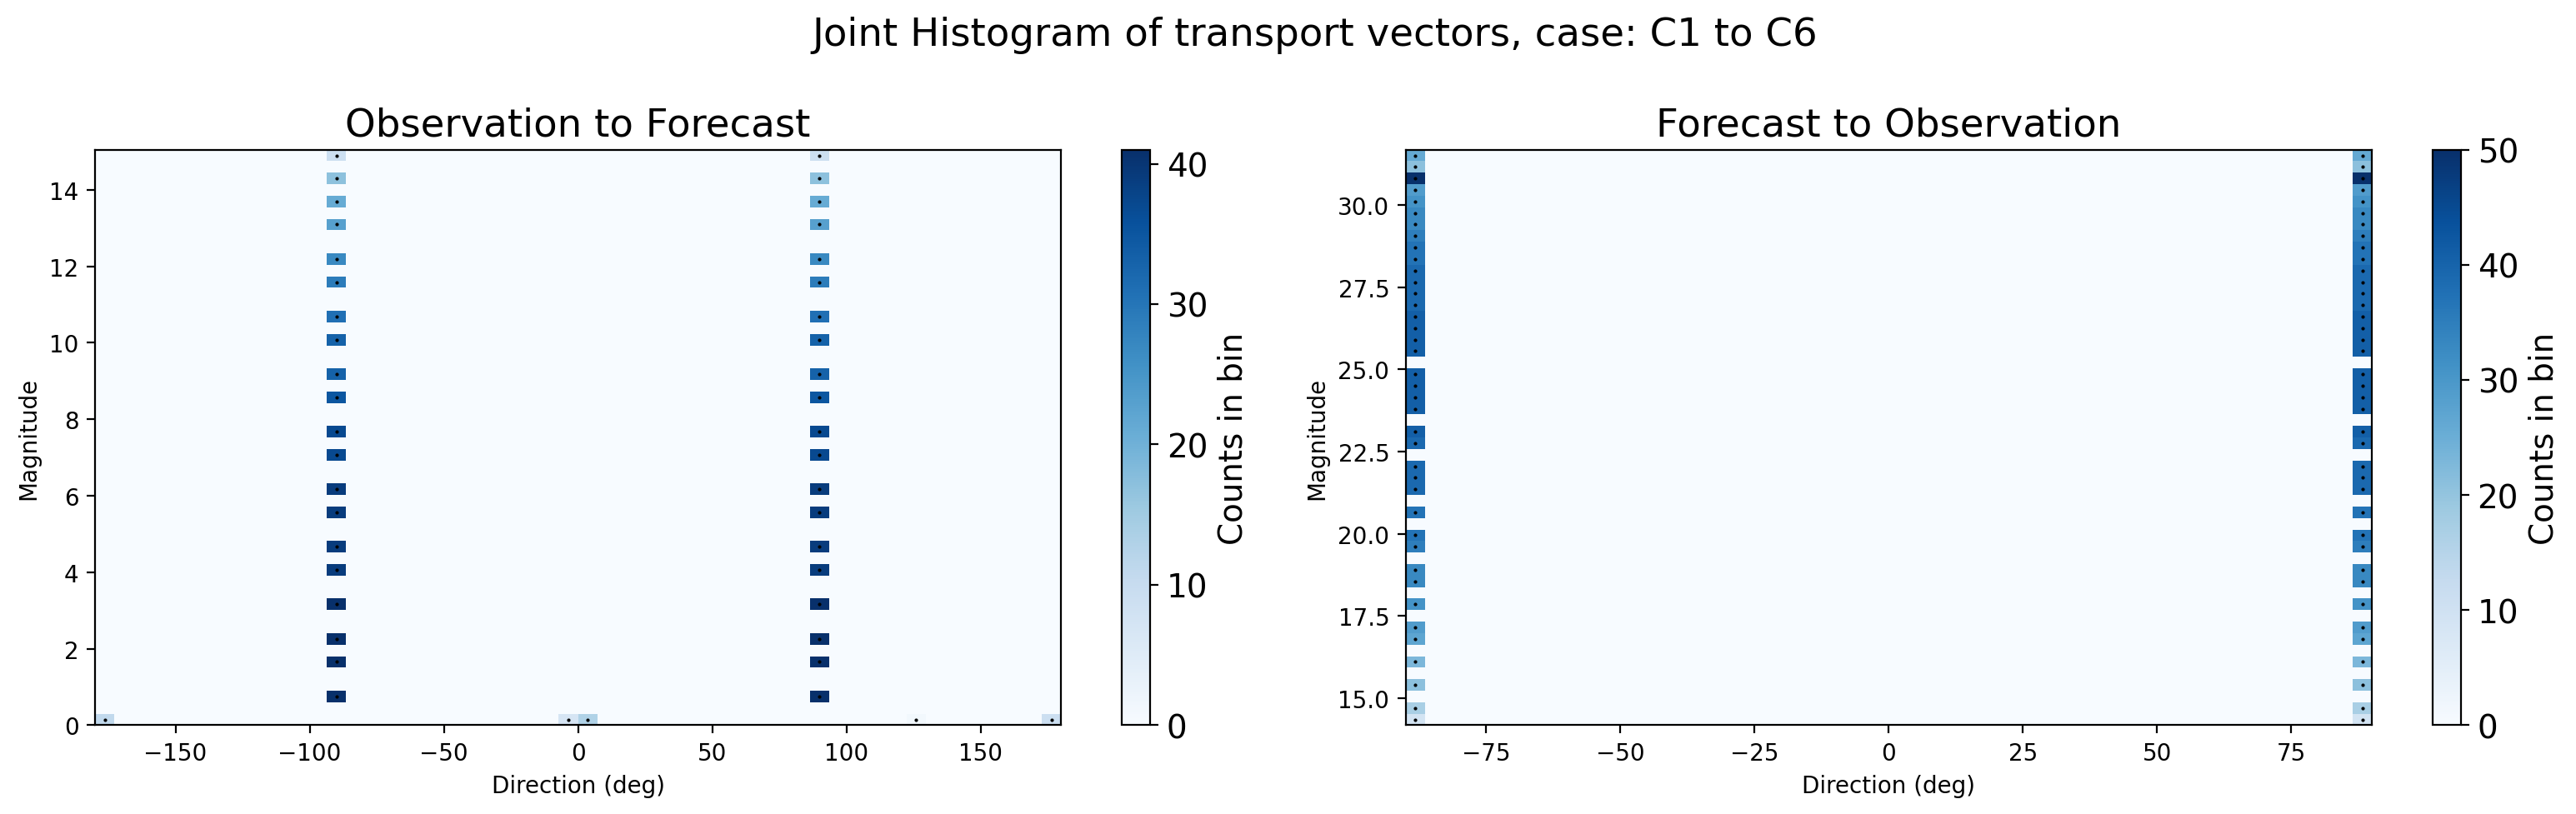

In [11]:
# Assuming v0 and u0 are already defined tensors
v0 = -(V0 - u0) # debiased vector: Observation to Forecast
L = 200 # length scale of the grid - same  as the one used to define the grid

# Calculate the magnitude and direction of the transport vectors
mag1 = v0.norm(dim=1).numpy() * L
direction1 = torch.rad2deg(torch.arctan2(v0[:, 1], v0[:, 0])).numpy()

# Forecast to observation transport vector
v0_bias = -(V1 - u1)
mag2 = v0_bias.norm(dim=1).numpy() * L
direction2 = torch.rad2deg(torch.arctan2(v0_bias[:, 1], v0_bias[:, 0])).numpy()

# Define bins (shared for both histograms)
bins = 50

# Create a single figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5), dpi=200)
plt.rcParams.update({"font.size": 14})

# Plot the first histogram
hist1, xedges1, yedges1, img1 = axs[0].hist2d(
    direction1[~np.isnan(direction1)],
    mag1[~np.isnan(mag1)],
    bins=bins,
    cmap="Blues",
)
fig.colorbar(img1, ax=axs[0], label="Counts in bin")
axs[0].set_title("Observation to Forecast")
axs[0].set_xlabel("Direction (deg)")
axs[0].set_ylabel("Magnitude")

# Overlay black points for non-empty bins on the first plot
xcenters1 = 0.5 * (xedges1[:-1] + xedges1[1:])
ycenters1 = 0.5 * (yedges1[:-1] + yedges1[1:])
for i in range(len(xcenters1)):
    for j in range(len(ycenters1)):
        if hist1[i, j] > 0:
            axs[0].plot(
                xcenters1[i], ycenters1[j], "ko", markersize=0.5
            )  # 'ko' means black circle

# Plot the second histogram
hist2, xedges2, yedges2, img2 = axs[1].hist2d(
    direction2[~np.isnan(direction2)],
    mag2[~np.isnan(mag2)],
    bins=bins,
    cmap="Blues",
)
fig.colorbar(img2, ax=axs[1], label="Counts in bin")
axs[1].set_title("Forecast to Observation")
axs[1].set_xlabel("Direction (deg)")
axs[1].set_ylabel("Magnitude")

# Overlay black points for non-empty bins on the second plot
xcenters2 = 0.5 * (xedges2[:-1] + xedges2[1:])
ycenters2 = 0.5 * (yedges2[:-1] + yedges2[1:])
for i in range(len(xcenters2)):
    for j in range(len(ycenters2)):
        if hist2[i, j] > 0:
            axs[1].plot(
                xcenters2[i], ycenters2[j], "ko", markersize=0.5
            )  # 'ko' means black circle

# Optional: Add annotations or other features
# Example: Adding an arrow in the second plot
# arrow_x = np.rad2deg(np.arctan2([-5], [3]))  # direction (degrees)
# arrow_y = 3 / 601 + 5 / 501  # magnitude
# axs[1].annotate('Target Bin', xy=(arrow_x, arrow_y), xytext=(-50, 0.03),
#                 arrowprops=dict(facecolor='red', shrink=0.05),
#                 fontsize=12, color='red')

# Show the plots
plt.suptitle(
    "Joint Histogram of transport vectors, case: {} to {}".format(case[0], case[1])
)

plt.tight_layout()
plt.show()

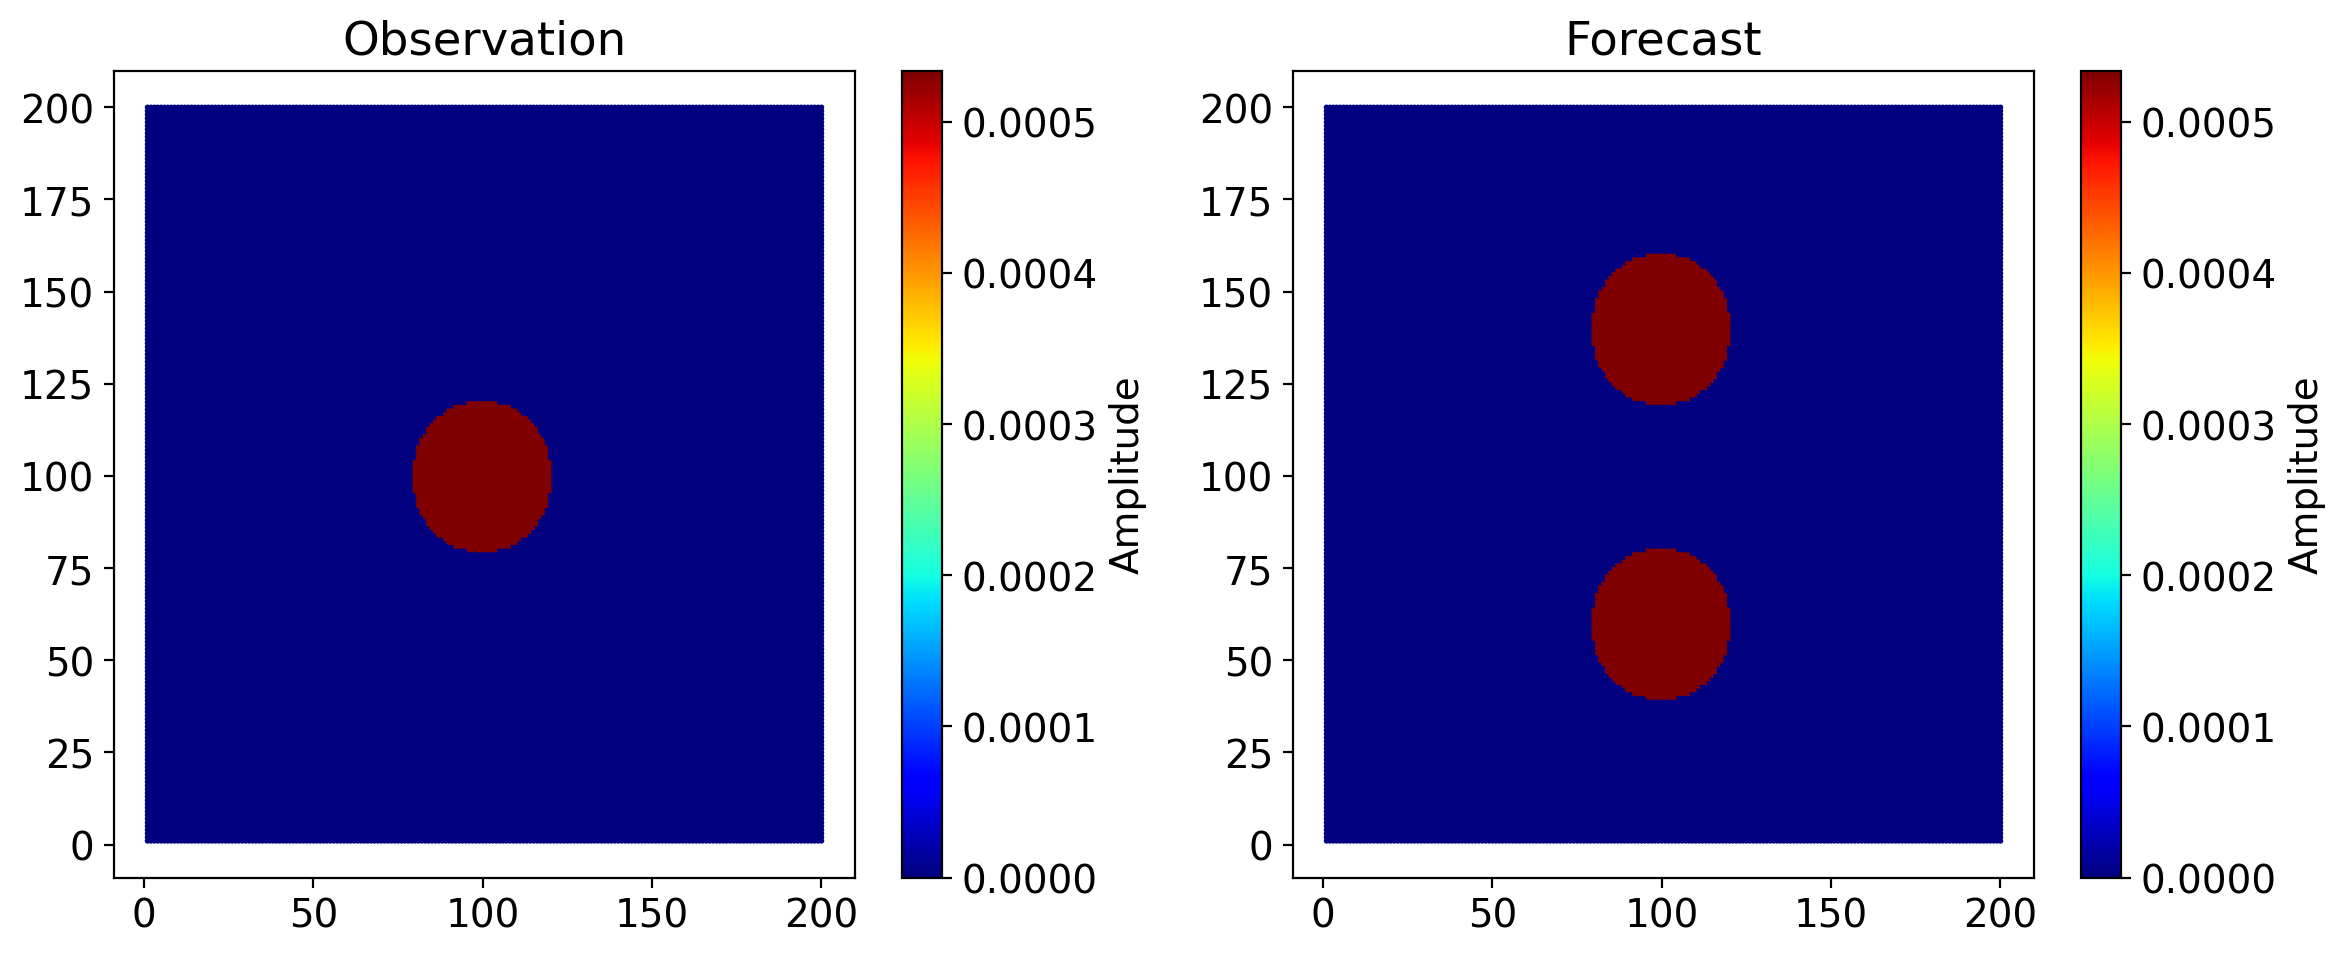

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=200)

plt.rcParams.update({"font.size": 14})

# First plot
ax = axs[0]
scatter = ax.scatter(X[:, :, 0]*L, X[:, :, 1]*L, c=alpha, s=1, cmap='jet')

fig.colorbar(
    scatter, ax=ax, label="Amplitude"
)  # Attach colorbar to the correct subplot

ax.set_title("Observation")
# ax.set(xlim=(0, cutout_dom.shape[1]), ylim=(0, cutout_dom.shape[0])) # 200

# Second plot
ax = axs[1]
scatter = ax.scatter(Y[:, :, 0]*L, Y[:, :, 1]*L, c=beta, s=1, cmap='jet')

fig.colorbar(
    scatter, ax=ax, label="Amplitude"
)  # Attach colorbar to the correct subplot

ax.set_title("Forecast")
# ax.set(xlim=(0, cutout_dom.shape[1]), ylim=(0, cutout_dom.shape[0])) # 200

plt.tight_layout()
plt.show()

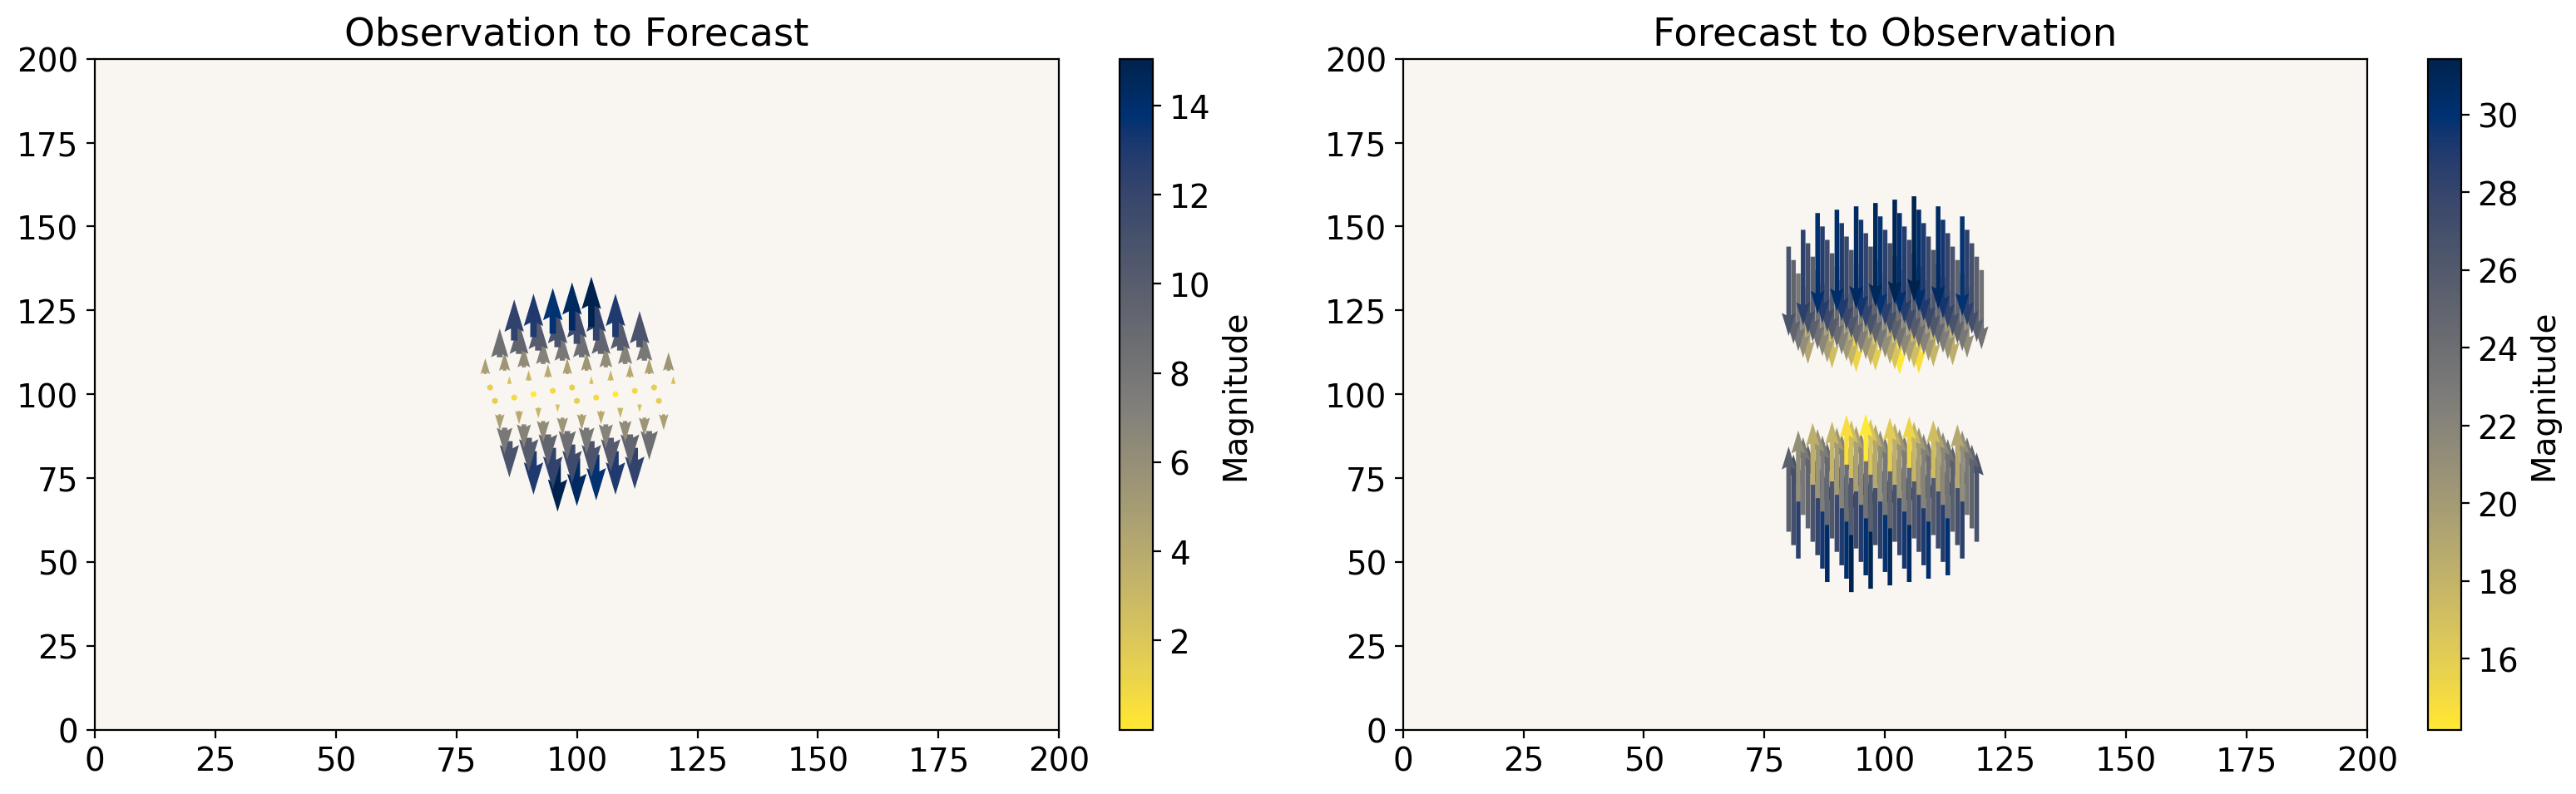

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), dpi=200)

plt.rcParams.update({"font.size": 14})

# First plot
ax = axs[0]
ax.set(xlim=(0, 200))
v0 = (V0 - u0) * 200  # Adjust vector field
step = 17
colors = torch.norm(v0[::step, :], dim=1).numpy()
colors[np.isnan(colors)] = 0
X_flat = X.reshape(-1, 2) * 200
index = colors > 0
quiv = ax.quiver(
    X_flat[::step, 0][index],
    X_flat[::step, 1][index],
    -v0[::step, 0][index],
    -v0[::step, 1][index],
    colors[index],
    cmap="cividis_r",
    angles="xy",
    scale_units="xy",
    scale=1,
)
fig.colorbar(
    quiv, ax=ax, label="Magnitude"
)  # Attach colorbar to the correct subplot
ax.set_facecolor("#f9f6f1")  # Set background color for this subplot
ax.set_title("Observation to Forecast")
ax.set(xlim=(0, 200), ylim=(0, 200))

# Second plot
ax = axs[1]
ax.set(xlim=(0, 200))
v0 = (V1 - u1) * 200  # Adjust vector field
colors = torch.norm(v0[::step, :], dim=1).numpy()
colors[np.isnan(colors)] = 0
X_flat = X.reshape(-1, 2) * 200
index = colors > 0
quiv = ax.quiver(
    X_flat[::step, 0][index],
    X_flat[::step, 1][index],
    -v0[::step, 0][index],
    -v0[::step, 1][index],
    colors[index],
    cmap="cividis_r",
    angles="xy",
    scale_units="xy",
    scale=1,
)
fig.colorbar(
    quiv, ax=ax, label="Magnitude"
)  # Attach colorbar to the correct subplot
ax.set_facecolor("#f9f6f1")  # Set background color for this subplot
ax.set_title("Forecast to Observation")

ax.set(xlim=(0, 200), ylim=(0, 200))

# plt.suptitle('C1C1 Transport Vectors', y=0.95)
plt.tight_layout()
plt.show()

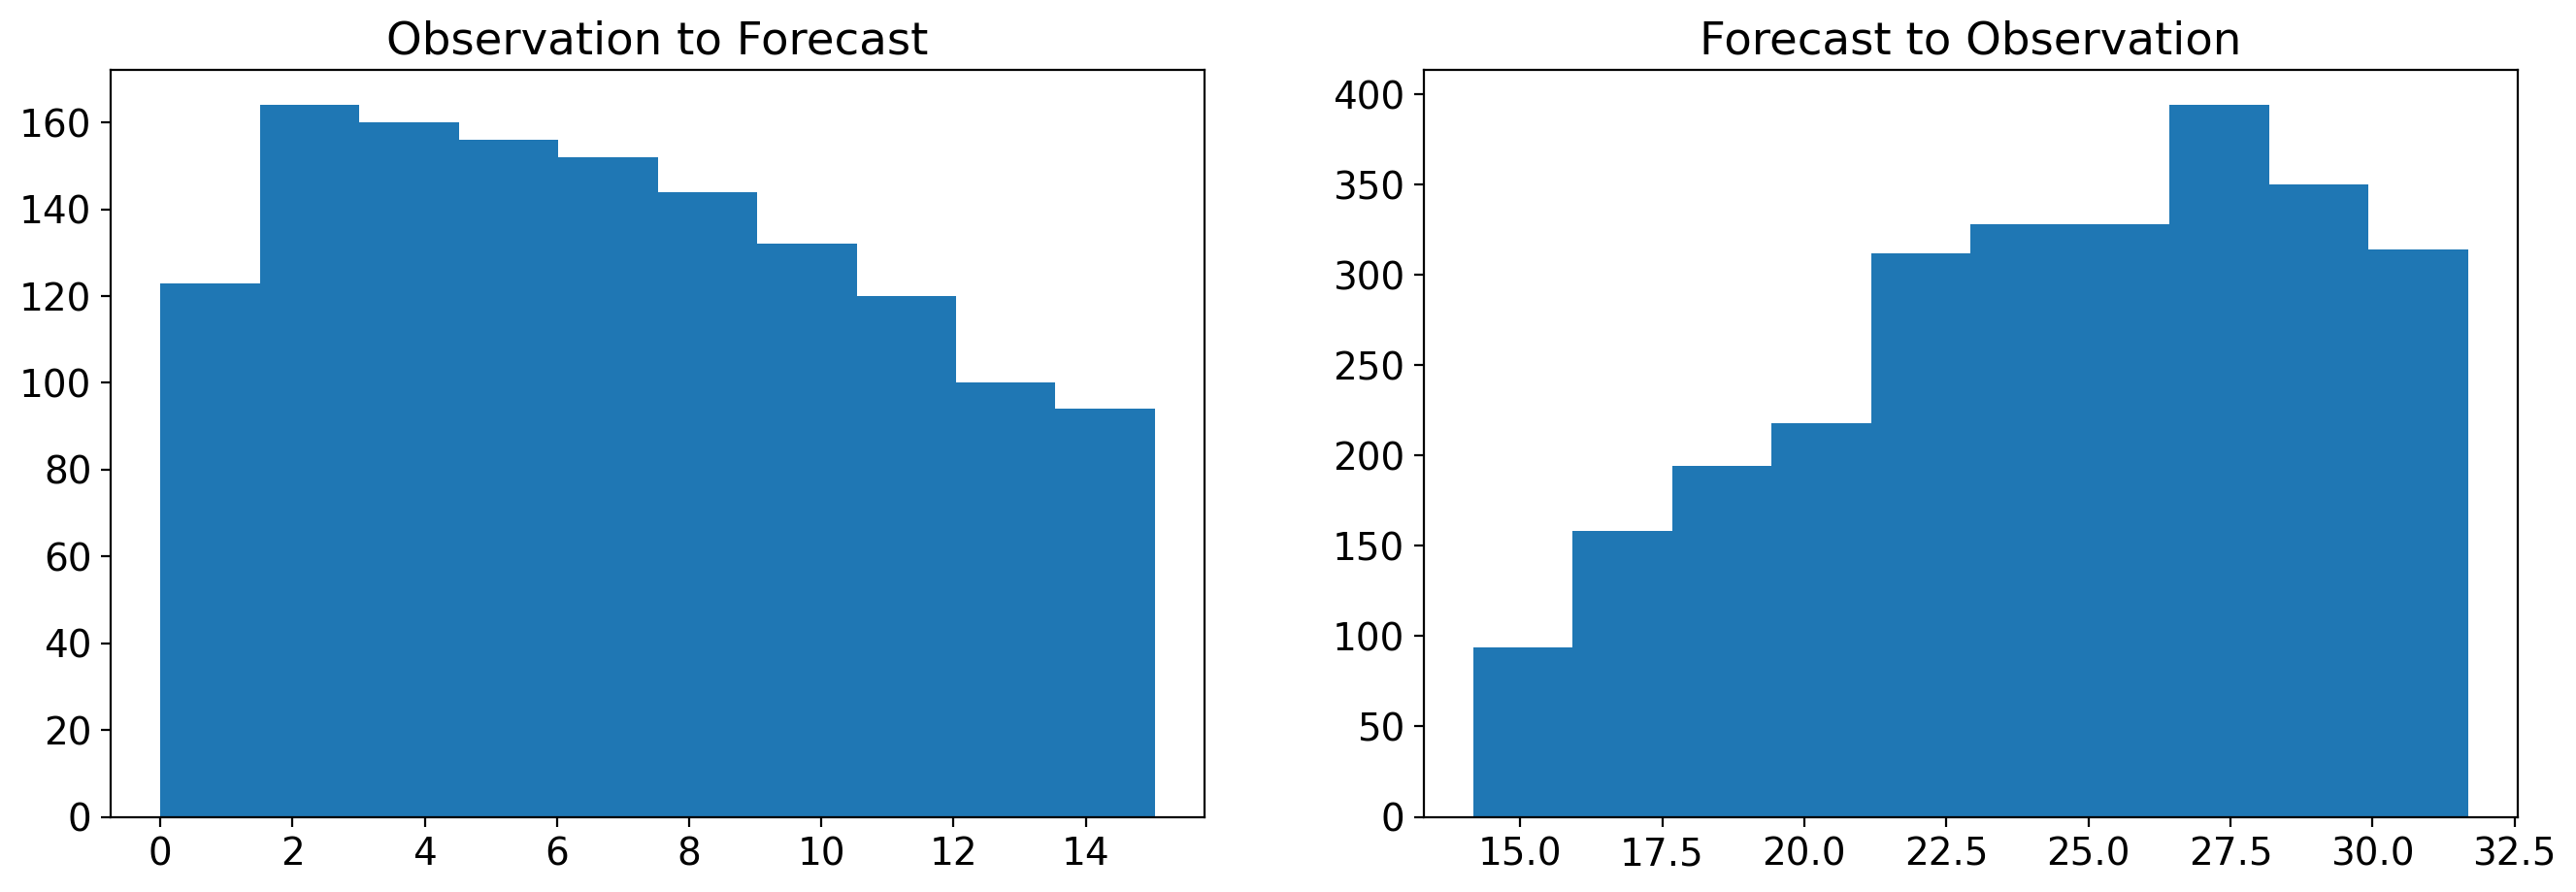

In [14]:
# histogram of magnitude only (not direction)

fig, axs = plt.subplots(1, 2, figsize=(16, 5), dpi=200)

axs[0].set_title("Observation to Forecast")
axs[0].hist(((V0 - u0) * 200).norm(dim=-1))

axs[1].set_title("Forecast to Observation")
axs[1].hist(((V1 - u1) * 200).norm(dim=-1))
plt.show()